<a href="https://colab.research.google.com/github/kvikik/MMO/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_5_2_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 5.2. Обрабокта текстовых данных



## Цель занятия:

Изучить методы обработки текстовых данных, очистки реализовать модели кластеризации и научиться предсказывать кластера с помощью алгоритмов: к-ближайших соседей, дерево принятия решений

In [ ]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 80.4 MB/s eta 0:00:00


In [ ]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

### 1. Загрузка данных из SQLite в pandas

Предполагаем, что база `articles.db` уже создана и содержит таблицу `articles`
со столбцами:

- `guid` – UUID (строка),
- `title` – заголовок,
- `description` – полный текст статьи,
- `published_at` – дата/время публикации (строка в ISO-формате),
- `comments_count` – количество комментариев (есть пропуски),
- `created_at_utc` – дата/время вставки записи в БД,
- `rating` – дробное число 0–5.

In [ ]:
DB_FILE = "articles.db"

# Открываем соединение с SQLite
conn = sqlite3.connect(DB_FILE)

# Читаем всю таблицу articles в DataFrame
df = pd.read_sql_query("SELECT * FROM articles;", conn)

# Закрываем соединение
conn.close()

In [ ]:
df

,guid,title,description,published_at,comments_count,created_at_utc,rating
0,b67693c3-07be-476a-ad2c-905fc4d14695,Разгром Наполеона на Березине: французская кат...,Большинство из нас видит Отечественную войну 1...,2020-11-29T22:25:32,NaN,2025-12-05T10:57:57,2.86
1,b38dee94-2609-425c-9af0-da87ef9fac88,Перовскиты объединили с кремнием в солнечных б...,Научная работа с описанием исследования и резу...,2020-12-15T02:48:56,168.0,2025-12-05T10:57:57,4.46
2,f6bbc6ef-4789-4c59-a158-bbd64f875212,AstraZeneca и разработчики российского «Спутни...,Англо-шведская биофармацевтическая компания As...,2020-12-12T01:42:21,762.0,2025-12-05T10:57:57,4.81
3,934b9cf2-5f83-4ace-b0cd-5440d6056c1a,Delta IV Heavy успешно вывела на орбиту спутни...,"Отрыв от стартового стола произошел в четверг,...",2020-12-12T02:31:36,159.0,2025-12-05T10:57:57,0.26
4,a19402c0-4079-486a-96db-266015335816,Французские военные рассматривают возможность ...,О необычном ходе мысли французских военных соо...,2020-12-12T02:35:47,701.0,2025-12-05T10:57:57,2.35
...,...,...,...,...,...,...,...
22949,57b74bac-4611-4bf4-a9b4-4b2fb2670714,Раковые клетки показали способность переходить...,Острый миелоидный лейкоз (ОМЛ) — злокачественн...,2021-03-15T22:11:38,668.0,2025-12-05T10:57:58,2.47
22950,fa3ad6d6-cec7-4359-82fa-bb32268e270f,Ученые «дезинформировали» хищников ради спасен...,Чтобы правильно ориентироваться в окружающей с...,2021-03-15T23:50:19,367.0,2025-12-05T10:57:58,3.27
22951,6d93534c-0270-446e-84d0-c9862302275c,В ЦАГИ испытали модель российско-китайского ши...,В Центральном аэрогидродинамическом институте ...,2021-03-16T01:30:14,NaN,2025-12-05T10:57:58,3.32
22952,c67d9d12-7177-4d6d-86c5-56585d1a2e55,Опубликовано самое четкое видео успешного поле...,Короткий ролик посвящен главному на данный мом...,2021-03-18T14:15:00,197.0,2025-12-05T10:57:58,0.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22954 entries, 0 to 22953
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            22954 non-null  object 
 1   title           22954 non-null  object 
 2   description     22954 non-null  object 
 3   published_at    22954 non-null  object 
 4   comments_count  16081 non-null  float64
 5   created_at_utc  22954 non-null  object 
 6   rating          22954 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.2+ MB


Приведём строковые даты к `datetime`, чтобы с ними можно было работать как с временными признаками.  
Это не обязательно для текстовой части, но полезно для полноты примера.


In [ ]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df["created_at_utc"] = pd.to_datetime(df["created_at_utc"], errors="coerce")

df[["published_at", "created_at_utc"]].head()

,published_at,created_at_utc
0,2020-11-29 22:25:32,2025-12-05 10:57:57
1,2020-12-15 02:48:56,2025-12-05 10:57:57
2,2020-12-12 01:42:21,2025-12-05 10:57:57
3,2020-12-12 02:31:36,2025-12-05 10:57:57
4,2020-12-12 02:35:47,2025-12-05 10:57:57


Посмотрим распределение рейтинга и пропусков в `comments_count`.


Пропуски в comments_count: 6873
Пропуски в rating: 0


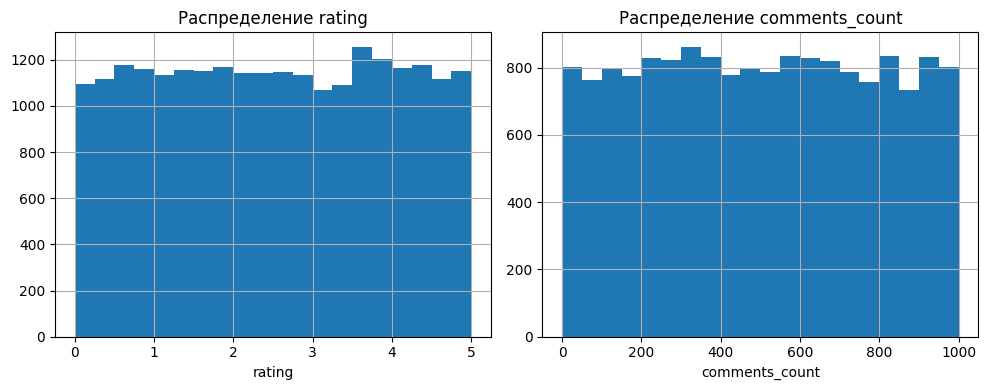

In [ ]:
print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0], bins=20)
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1], bins=20)
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()


In [ ]:
# Скачаем русские стоп-слова NLTK (один раз)
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 2. Предобработка текста

### 2.1. Общая схема

1. Привести текст к нижнему регистру.
2. Оставить только буквы (`[А-Яа-яA-Za-z]+`).
3. Разбить на токены (слова).
4. Удалить стоп-слова и короткие токены.
5. Для каждого слова получить **лемму** через `pymorphy3`.

Так мы уменьшаем размерность словаря и «склеиваем» разные формы слова.

P.S. `pymorphy3` работает только с русскими словами, английские будем оставлять как есть.


In [ ]:
# Инициализируем морфоанализатор и список стоп-слов
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas


Проверим функцию на одном примере (из первых описаний).


In [ ]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]


Большинство из нас видит Отечественную войну 1812 года глазами ее величайшего популяризатора – Льва  ...


['большинство',
 'видеть',
 'отечественный',
 'война',
 'год',
 'глаз',
 'великий',
 'популяризатор',
 'лев',
 'толстой',
 'формально',
 'война',
 'мир',
 'книга',
 'художественный',
 'автор',
 'многие',
 'читатель',
 'воспринимать',
 'эпический',
 'полотно',
 'реальный',
 'мир',
 'который',
 'толстой',
 'просто',
 'вплести',
 'судьба',
 'кой',
 'персонаж',
 'мелкий',
 'толстовизация',
 'история',
 'отечественный',
 'война',
 'многие',
 'сей',
 'пора',
 'считать',
 'кутузов',
 'полководец',
 'действовать',
 'мудро',
 'якобы',
 'хотеть',
 'давать',
 'наполеон',
 'бородинский',
 'сражение',
 'планировать',
 'скорее',
 'отдать',
 'москва',
 'напор',
 'александр',
 'двор',
 'это',
 'сражение',
 'дать',
 'кутузов',
 'хотеть',
 'жертва',
 'сторона',
 'русский',
 'армия',
 'поэтому',
 'избегать',
 'решительный',
 'сражение',
 'француз',
 'отступление',
 'вдоль',
 'старый',
 'смоленский',
 'дорога',
 'также',
 'поэтому',
 'окружить',
 'красный',
 'глубина',
 'россия',
 'граница',
 'очень',
 'д

### 2.2. Применение к корпусу

На 22k статей полная лемматизация может занять заметное время,  
особенно в условиях учебной машины / ноутбука.


In [ ]:
N_DOCS = 15000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]



real	0m0.000s
user	0m0.000s
sys	0m0.000s


['большинство',
 'видеть',
 'отечественный',
 'война',
 'год',
 'глаз',
 'великий',
 'популяризатор',
 'лев',
 'толстой',
 'формально',
 'война',
 'мир',
 'книга',
 'художественный',
 'автор',
 'многие',
 'читатель',
 'воспринимать',
 'эпический',
 'полотно',
 'реальный',
 'мир',
 'который',
 'толстой',
 'просто',
 'вплести',
 'судьба',
 'кой',
 'персонаж',
 'мелкий',
 'толстовизация',
 'история',
 'отечественный',
 'война',
 'многие',
 'сей',
 'пора',
 'считать',
 'кутузов']

## 3. Обучение Word2Vec и векторизация документов

### 3.1. Интуиция Word2Vec

Идея Word2Vec:

> Если два слова часто встречаются в **похожих контекстах**, их смыслы близки → их векторы должны быть близки в векторном пространстве.

То есть модель **не знает** грамматики и словарей, она просто учится по статистике
совместных появлений слов в окне контекста.

Две основные архитектуры:

- **CBOW (Continuous Bag-of-Words)** — пытается по контексту предсказать слово.
- **Skip-gram** — наоборот, по слову предсказывает слова контекста.

На практике:
- CBOW быстрее и лучше для частых слов.
- Skip-gram лучше ловит редкие слова, но обучается медленнее.

В `gensim` это переключается флагом `sg`:
- `sg=0` → CBOW
- `sg=1` → Skip-gram

### 3.2. Основные гиперпараметры Word2Vec

- `vector_size` — размерность вектора слова (обычно 100–300).
  - Больше размерность → богаче представление, но, дольше обучать
- `window` — «окно» контекста (в словах).
  - `window=5` означает, что мы смотрим 5 слов слева и справа (до 10 слов контекста).
  - Большое окно → больше «тематическая» близость; маленькое окно → более синтаксическая.
- `min_count` — минимальная частота слова, чтобы попасть в словарь.
  - Если `min_count=5`, все слова, встретившиеся < 5 раз, игнорируются.
  - Это сильно уменьшает размер словаря и шум от опечаток/редких форм.
- `workers` — число потоков; влияет только на скорость обучения.
- `sg` — режим (0 = CBOW, 1 = Skip-gram).
- `epochs` — сколько «проходов» по корпусу сделать.
  - Слишком мало — модель «недоучится».
  - Слишком много — можно начать переобучаться под шум корпуса.

### 3.3. Обучение Word2Vec на наших текстах

Мы используем:
- `vector_size=100` — компромисс между качеством и скоростью.
- `window=5` — типичное значение для общего языка.
- `min_count=5` — отфильтровываем очень редкие слова.
- `sg=1` — Skip-gram, чтобы лучше обрабатывать редкие слова.
- `epochs=10` — для небольшого корпуса этого обычно достаточно.

Важно: `sentences=tokenized_texts` — список списков лемм,
которые мы получили на шаге предобработки.


In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

Посмотрим, какие слова похожи на одно из ключевых слов корпуса.


In [ ]:
w2v_model.wv.most_similar("наука", topn=10)


[('популяризатор', 0.664910078048706),
 ('рикэн', 0.6576319932937622),
 ('антропология', 0.6434378027915955),
 ('зоология', 0.6425188183784485),
 ('рамна', 0.6405943632125854),
 ('имкб', 0.6237289309501648),
 ('геронтология', 0.6178988814353943),
 ('биоинформатика', 0.6166847348213196),
 ('мгу', 0.6151236295700073),
 ('педагогический', 0.6123496890068054)]

In [ ]:
for test_word in ["наука", "страна", "космос", "владивосток", "вакцина"]:
    if test_word not in w2v_model.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v_model.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")



Похожие слова для «наука»:
  популяризатор   0.665
  рикэн           0.658
  антропология    0.643
  зоология        0.643
  рамна           0.641

Похожие слова для «страна»:
  государство     0.743
  россия          0.708
  индия           0.704
  вакцинироваться 0.676
  снг             0.676

Похожие слова для «космос»:
  космический     0.780
  мкс             0.639
  луна            0.639
  марс            0.634
  околоземный     0.617

Похожие слова для «владивосток»:
  севастополь     0.765
  величество      0.752
  недостроенный   0.743
  краснодарский   0.724
  тартус          0.716

Похожие слова для «вакцина»:
  препарат        0.762
  вакцинация      0.732
  коронавирус     0.725
  zmapp           0.719
  zebov           0.716


### 3.2. Векторы документов

Чтобы получить вектор **документа**, можно усреднить векторы
всех слов, которые есть в словаре Word2Vec.


In [ ]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape


(15000, 120)

Первые несколько векторов (каждый – размерности 100).


In [ ]:
doc_vectors[:3]


array([[ 0.02530852,  0.0228888 ,  0.10179687,  0.05905585, -0.05975329,
        -0.1935153 ,  0.16292325,  0.00286597,  0.03499866,  0.22794645,
         0.06733502, -0.02661751,  0.14543393, -0.01172368, -0.03041402,
        -0.10242568,  0.09012047, -0.10372175, -0.2596653 ,  0.10263615,
         0.16771407, -0.21416572,  0.04847549, -0.20699535, -0.04833806,
         0.00062241, -0.01987215,  0.08814347, -0.01585828, -0.1391333 ,
         0.28037506, -0.41978464,  0.12381271,  0.10606574,  0.06634346,
         0.16727915,  0.15656675, -0.04627348,  0.08477358,  0.14151514,
         0.25224862, -0.11023706, -0.14396574, -0.15258846,  0.28554732,
         0.184557  ,  0.05602619, -0.09311527,  0.03293195, -0.06238625,
        -0.1245176 , -0.17111874, -0.03128298, -0.05236884,  0.21205871,
         0.06292521,  0.10627291,  0.05455378,  0.30520436,  0.10134964,
        -0.11771442,  0.07508595, -0.20055564,  0.05873663,  0.13217676,
        -0.2128499 ,  0.03188613,  0.0935602 ,  0.0

## 4. Снижение размерности через PCA

### 4.1. Зачем PCA

Word2Vec даёт векторы размерности 100 (или больше).  
Для визуализации и некоторых алгоритмов удобно перейти к 2–3 измерениям.

Используем **Principal Component Analysis (PCA)**:

- линейный метод,
- сохраняет как можно больше дисперсии,
- часто используется как «быстрая» предобработка перед кластеризацией.


In [ ]:
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]


array([[-0.09330286, -0.05679901],
       [ 0.03843152,  0.00897304],
       [ 0.09079804,  0.30062956],
       [-0.54677767, -0.0877846 ],
       [-0.04317356,  0.1688483 ]], dtype=float32)

Добавим полученные координаты к датафрейму, чтобы удобно было визуализировать
и связывать с метаданными.


In [ ]:
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()


,guid,title,description,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,b67693c3-07be-476a-ad2c-905fc4d14695,Разгром Наполеона на Березине: французская кат...,Большинство из нас видит Отечественную войну 1...,2020-11-29 22:25:32,NaN,2025-12-05 10:57:57,2.86,-0.093303,-0.056799
1,b38dee94-2609-425c-9af0-da87ef9fac88,Перовскиты объединили с кремнием в солнечных б...,Научная работа с описанием исследования и резу...,2020-12-15 02:48:56,168.0,2025-12-05 10:57:57,4.46,0.038432,0.008973
2,f6bbc6ef-4789-4c59-a158-bbd64f875212,AstraZeneca и разработчики российского «Спутни...,Англо-шведская биофармацевтическая компания As...,2020-12-12 01:42:21,762.0,2025-12-05 10:57:57,4.81,0.090798,0.300630
3,934b9cf2-5f83-4ace-b0cd-5440d6056c1a,Delta IV Heavy успешно вывела на орбиту спутни...,"Отрыв от стартового стола произошел в четверг,...",2020-12-12 02:31:36,159.0,2025-12-05 10:57:57,0.26,-0.546778,-0.087785
4,a19402c0-4079-486a-96db-266015335816,Французские военные рассматривают возможность ...,О необычном ходе мысли французских военных соо...,2020-12-12 02:35:47,701.0,2025-12-05 10:57:57,2.35,-0.043174,0.168848


Построим scatter-график всех документов в пространстве первых двух главных компонент.


## 5. Кластеризация документов с помощью DBSCAN

### 5.1. Идея DBSCAN

**DBSCAN**

Мы будем кластеризовать уже **PCA-сжатые** векторы (`doc_vectors_2d`),
так как в 100-мерном пространстве DBSCAN может работать нестабильно.


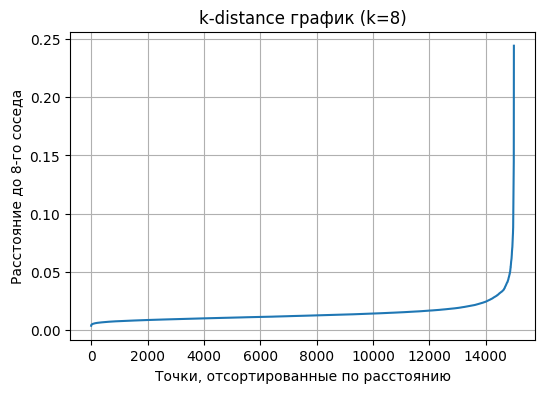

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 8  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()


In [ ]:
dbscan = DBSCAN(eps=0.010, min_samples=8)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)


(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

Добавим метку кластера в датафрейм и посмотрим пример.


In [ ]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)


,title,cluster
0,Разгром Наполеона на Березине: французская кат...,-1
1,Перовскиты объединили с кремнием в солнечных б...,0
2,AstraZeneca и разработчики российского «Спутни...,-1
3,Delta IV Heavy успешно вывела на орбиту спутни...,-1
4,Французские военные рассматривают возможность ...,1
5,Исследователи разработали инновационное покрыт...,2
6,Samsung полностью останавливает продажи Galaxy...,-1
7,Китайские ученые научили нейросеть самостоятел...,3
8,В США построят телескоп для поиска «второй Земли»,-1
9,Тайна Бермудского треугольника,-1


Визуализация кластеров: каждой точке (документу) присвоим цвет кластера.


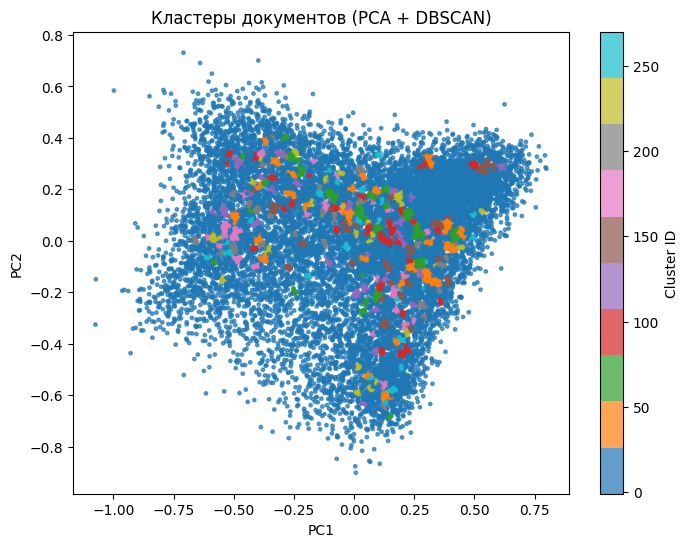

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Можно посмотреть несколько документов из одного кластера, чтобы увидеть,
объединяет ли их общая тема.

Ниже пример для кластера `0` (если он есть).


In [ ]:
cluster_id = 5

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)


,title
17,Обнаружены подтверждения изменений климата в А...
1196,Ученые сделали шашлык из броненосцев
2125,«Птица счастья» вымерла
2293,Homo sapiens достиг Китая 100 тыс. лет назад?
2410,Алмаз удалось сжать почти в четыре раза
3452,"Ученые открыли древнюю рептилию, жившую до дин..."
3777,Хоббиты Толкиена родом с острова Флорес?
3856,Ученые создали модель искусственной клетки для...
4109,Разумные инопланетяне должны быть намного круп...
5120,"Чтобы лучше понять жизнь, ученые отправили в к..."


## 6. Подготовка признаков для supervised-задачи

Теперь будем решать задачу:

> Научиться по признакам статьи **предсказывать её кластер**, полученный ранее алгоритмом DBSCAN.

Это типичный пример *pseudo-labeling*: мы сначала провели **обучение без учителя**  (DBSCAN),
получили кластерные метки, а затем используем их как «цель» в **обучени с учителем** обучении
(Decision Tree, k-NN).

### 6.1. Что используем в качестве признаков

- **Документный вектор** из Word2Vec (`doc_vectors`, размерность 100).
- Числовые признаки:
  - `comments_count` (с пропусками),
  - `rating`.

Для числовых признаков используем **импьютацию** (`SimpleImputer`, стратегия `median`),
так как в `comments_count` есть `NaN`.

### 6.2. Что делаем с кластером `-1`

DBSCAN помечает «шум» значением `cluster = -1`.  
Для простоты будем **исключать** такие объекты из supervised-задачи, чтобы не пытаться
учить модель предсказывать шум.


In [ ]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()


Всего объектов для supervised-задачи: 10506 из 15000


,count
cluster,
0,52
1,6
2,43
3,24
4,8
...,...
453,6
454,5
455,5


Подготовим числовые признаки (`comments_count`, `rating`) и выполним импьютацию пропусков.


In [ ]:
numeric_features = df_sup[["comments_count", "rating"]].copy()

imputer = SimpleImputer(strategy="median")

numeric_imputed = imputer.fit_transform(numeric_features)
numeric_imputed[:5]


array([[4.98e+02, 2.86e+00],
       [1.68e+02, 4.46e+00],
       [1.59e+02, 2.60e-01],
       [7.01e+02, 2.35e+00],
       [4.98e+02, 3.30e-01]])

Теперь соберём финальную матрицу признаков `X`:

- первая часть: Word2Vec-векторы документов,
- вторая часть: числовые признаки после импьютации.

Важно: использовать те же документные векторы, но взять только те строки,
которые остались после фильтрации `cluster != -1`.


In [ ]:
# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X = np.hstack([doc_vectors_sup, numeric_imputed])
X.shape


(10506, 102)

Разобьём данные на `train` и `test` с сохранением соотношения кластеров (`stratify=y`).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((8404, 102), (2102, 102))

## 7. Обучение и оценка моделей (предсказание кластера)

Обучим две классические модели:

1. **Decision Tree** (`DecisionTreeClassifier`);
2. **k-Nearest Neighbors (k-NN)** (`KNeighborsClassifier`).

Оценивать будем по:

- `accuracy`,
- `classification_report` (precision/recall/F1 по каждому кластеру).

Важно понимать, что качество здесь ограничено тем,
насколько «читаемы» сами кластеры DBSCAN; иногда они могут пересекаться или быть слабо отделимыми.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


### 7.1. Decision Tree


In [ ]:
dt_clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
)


dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))


Decision Tree accuracy: 0.38106565176022833

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.09      0.18      0.12        11
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         9
           3       0.12      0.40      0.18         5
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.25      0.17      0.20         6
           7       0.14      0.25      0.18        60
           8       0.46      0.73      0.56       240
           9       0.00      0.00      0.00        12
          10       0.77      0.85      0.81       571
          11       0.61      0.74      0.67       111
          12       0.00      0.00      0.00        11
          13       0.05      0.22      0.09         9
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 7.2. Подбор гиперпараметров k-NN через GridSearchCV

Будем подбирать:

- `n_neighbors` — число соседей,
- `weights` — схема взвешивания голосов (`uniform` / `distance`),
- `metric` — метрику расстояния (оставим `cosine`).

GridSearchCV будет:

- использовать **k-fold cross-validation** (по умолчанию `cv=5`),
- оптимизировать по метрике `accuracy`,
- в конце вернёт `best_estimator_`, который мы проверим на тестовой выборке.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Базовый классификатор (без фиксированных гиперпараметров)
knn_base = KNeighborsClassifier()

# Сетка гиперпараметров для перебора
param_grid = {
    "n_neighbors": [3, 5, 10, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "euclidean"],
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # использовать все доступные ядра
    verbose=1,     # чтобы видеть прогресс
)


grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший CV accuracy:", grid_knn.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Лучший CV accuracy: 0.41551641596555344


Используем найденный на кросс-валидации лучший классификатор и оценим его на тестовой выборке.


In [ ]:
best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("k-NN (best) accuracy на тесте:", accuracy_score(y_test, y_pred_knn))
print("\nClassification report (k-NN best):")
print(classification_report(y_test, y_pred_knn))


k-NN (best) accuracy на тесте: 0.41198858230256896

Classification report (k-NN best):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         6
           7       0.04      0.05      0.05        60
           8       0.40      0.75      0.52       240
           9       0.00      0.00      0.00        12
          10       0.63      0.98      0.77       571
          11       0.49      0.94      0.64       111
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
